**NOT YET UPDATED TO v0.2**

# SWYFT tutorial

This tutorial highlights three aspects of *swyft*.

- The general *swyft* API. It is somewhat verbose right now, but will be stream-lined in the future.
- For simple problems like linear regression *swyft* reproduces known results.
- Solving hard problems, like the marginalization over a high-dimensional nuiscance parameter space with $10^{18}$ modes, becomes (almost) as simple as linear regression.


In [91]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

## Imports

In [92]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install swyft

In [1]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# Import swyft
import swyft
DEVICE = 'cuda'

## Linear Regression Example

### Priors

We are interested in Bayesian parameter inference, so let's first get our priors straight.

In [2]:
prior = swyft.Prior({"a": ['uniform', -1., 1.], "b": ['uniform', -1., 1.]})

### Our "physics simulator"

We consider a simple linear regression problem.  To this end, we define a "line simulator", which produces a line giving two input parameters (corresponding to offset and slope).

In [3]:
def simulator(params):
    "Line simulator"
    p = np.linspace(-1, 1, 10)  # Nbin = 10
    mu = params['a'] + p*params['b']
    return dict(x=mu)

The simulator generates beautiful lines.

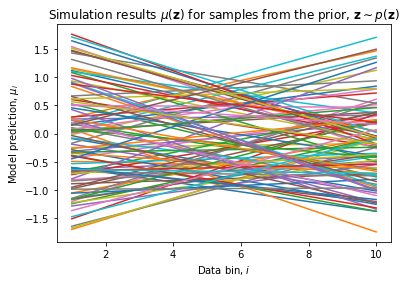

In [4]:
for _ in range(100):
    params = prior.sample(1)
    plt.plot(range(1, 11), simulator(params)['x']);
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Simulation results ${\mu}(\mathbf{z})$ for samples from the prior, $\mathbf{z}\sim p(\mathbf{z})$");

Assuming that measurement errors for each data bin are Gaussian, a typical likelihood-based analysis would now exploit the $\chi^2$ function
$$
\chi^2 = -2\ln p(\mathbf{x}_0|\mathbf{z}) = \sum_{i=1}^{N_\text{bins}} \frac{(\mu_i(\mathbf{z}) - x_{0,i})^2}{\sigma^2}\;,
$$
where $\mathbf{x}_0$ referes to the measured flux, $\boldsymbol{\mu}(\mathbf{z})$ is the result of the line simulator model given model parameters $\textbf{z}$, $\sigma$ refers to the standard deviation of the measurement noise, and $N_\text{bins} = 10$ is the number of bins. This is *not* what we will do here.

### Our "detector noise"

Instead, a likelihood-free (or simulator based) analysis is based on random draws from the likelihood (aka *forward model*), $\mathbf{x}\sim p(\mathbf{x}|\mathbf{z})$.  Since we are assuming in the current example that measurement noise is Gaussian, we just have to add zero-mean Gaussian noise to the simulator results.  We do this with a separate function.

In [5]:
def noise(obs, params = None, sigma=0.1):
    mu = obs['x']
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return dict(x=x)

Now we can generate noisy lines!

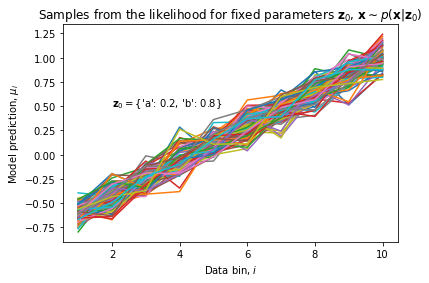

In [7]:
par0 = dict(a=0.2, b=0.8)

for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(par0))['x']);
plt.annotate("$\mathbf{z}_0 =$"+str(par0), (2, 0.5));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the likelihood for fixed parameters $\mathbf{z}_0$, $\mathbf{x} \sim p(\mathbf{x}|\mathbf{z}_0)$");

### The generative model

Data scientists sometimes talk about *generative models*.  For us, this refers simply to a sampler that both generates a random draw from the prior, $p(\mathbf{z})$, and subsequently a corresponding random draw from the forward model: $\mathbf{x}, \mathbf{z} \sim p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$.
Such $(\mathbf{x},\mathbf{z})$ pairs are samples from the generative model.  Drawing from the generative model and throwing away $\mathbf{z}$ is equivalent to sampling from the marginal likelihood (aka Bayesian evidence), $\mathbf{x} \sim p(\mathbf{x})$.

Let us plot random samples from the marginal likelihood!  We also show in red a sample from the forward model for our specific reference parameters ($\mathbf{z}_0$): $\mathbf{x}_0 \sim p(\textbf{x}|\textbf{z}_0)$.

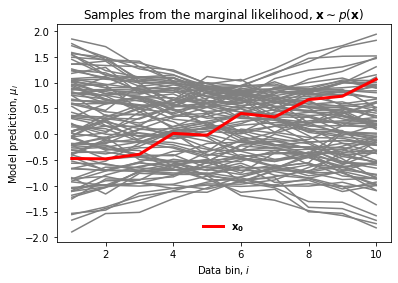

In [8]:
for _ in range(100):
    params = prior.sample(1)
    plt.plot(range(1, 11), noise(simulator(params))['x'], color='0.5');
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the marginal likelihood, $\mathbf{x} \sim p(\mathbf{x})$");

# Define mock data
obs0 = noise(simulator(par0))
plt.plot(range(1, 11), obs0['x'], lw = 3, color='r', label = "$\mathbf{x_0}$")
plt.legend(frameon = False);

Additional information: The noise could be also simulated within the function `simulator`, and the function `noise` could just do nothing. However, often the physics simulation is slow, but adding (Gaussian, Poission, etc) measurement noise is fast.  In these cases the split functions enable to train networks with different noise realizations without rerunning the simulator.  The basic logic is: simulator = slow, noise = fast.

## Step-by-step parameter estimation with *swyft* (verbose and without nesting)

Now we are ready to solve the inverse problem and derive the posterior $p(\mathbf{z}|\mathbf{x}_0)$, using *swyft*.  Let's do this step-by-step to highlight the important steps.  We will consider nesting as well as a convenience function for doing everything in one go further below.

### Instantiating the iP3 sample cache

First we have to instantiate a simulation cache, which is the place where all simulation results are stored. *swyft* offers the options to store them on disk (for later re-use) for simply in memory.  We chose the memory option here.

In [9]:
cache = swyft.MemoryCache(['a', 'b'], obs_shapes = {'x': (10,)})

Creating new cache.


### Filling iP3 sample cache with simulated data

The next step is to fill the iP3 sample cache with simulations over the complete prior range.  We do this by first generating an intensity object that covers the complete prior, then adding the necessary parameters points to the cache, and finally running the simulator for the newly added points.

Note: Run this cell twice and see what happens.

In [10]:
cache.grow(prior, 2000)
cache.simulate(simulator)

Simulate:   2%|▏         | 49/2043 [00:00<00:04, 486.11it/s]

  adding 2043 new samples to simulator cache.


Simulate: 100%|██████████| 2043/2043 [00:03<00:00, 628.10it/s]


### Extract training data from cache

We instantiate a `Points` object that pulls out the training data from the sample cache.  We also add the noise model here, which will be run each time a sample is picked from the point list.

In [11]:
indices = cache.sample(prior, 2000)
points = swyft.Points(indices, cache, noise)
print("Number of simulations in `points`:", len(points))

Number of simulations in `points`: 2043


### Estimate 1-dim marginal posteriors using a ratio estimator

We are now ready to instantiate a ratio estimator object and train it on the simulated points.

In [15]:
re = swyft.RatioEstimator(['a', 'b'], device=DEVICE)
re.train(points)

### Plot 1-dim marginal posteriors

We collect weighted posterior samples for the "observation" obs0.

In [16]:
samples = re.posterior(obs0, prior, n_samples = 100000)

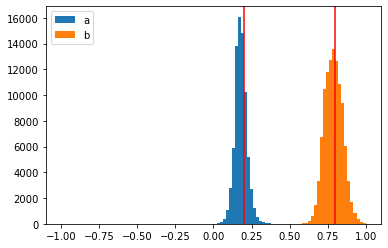

In [17]:
a = samples['params']['a']
b = samples['params']['b']
wa = samples['weights'][('a',)]
wb = samples['weights'][('b',)]
hist_a = plt.hist(a, weights = wa, bins = 100, label='a');
hist_b = plt.hist(b, weights = wb, bins = 100, label='b');
plt.axvline(par0['a'], color='r')
plt.axvline(par0['b'], color='r')
plt.legend();

Comparison of inferred errors (68% credible interval half-width) with expected 1-sigma uncertainty from Fisher forecasting

In [18]:
mean_a = np.average(a, weights = wa)
std_a = np.average((a-mean_a)**2, weights = wa)**0.5
mean_b = np.average(b, weights = wb)
std_b = np.average((b-mean_b)**2, weights = wb)**0.5
print("a = %.2f +- %.2f"%(mean_a, std_a))
print("b = %.2f +- %.2f"%(mean_b, std_b))

a = 0.18 +- 0.04
b = 0.79 +- 0.06


In [36]:
print("Fisher uncertainty for a = %.5f"%(0.1/((np.ones(10))**2).sum()**0.5))  # Based on Fisher forecasting
print("Fisher uncertainty for b = %.5f"%(0.1/((np.linspace(-1, 1, 10))**2).sum()**0.5))  # Fisher forecasting

Fisher uncertainty for a = 0.03162
Fisher uncertainty for b = 0.04954


It turns out that the estimated posteriors are wider than what is expected from Fisher forecasting. Given the very low number of training samples (just a 2000), this is no surprise.  There are two ways to fix this:
- Increase the amount of training data (try e.g. 10000 instead of 2000 above and re-run)
- Zoom into the relevant prefered parameter range, simulate more training data there, and train a new targeted ratio estimator

We will try the second option next.

## Nested parameter estimation with *swyft*

### A nested analysis loop

The next function implements the required analysis steps for a nested analysis.

The function `run` takes as input the target observation $\mathbf{x}_0$, the dimensionality of the parameter space $\mathbf{z}$, the simulator function and the (optional) noise function.

The analysis steps involve:
- Creation of simulation cache in memory
- Filling the simulation cache with parameter samples from the prior
- Running simulations for these parameter samples
- Training a neural network to estimate the posterior

Let's run the analysis for three rounds.

In [21]:
s = swyft.NestedRatios(simulator, prior, noise = noise, obs = obs0, device = DEVICE)
s.run(max_rounds = 3)

Simulate:   2%|▏         | 50/3007 [00:00<00:05, 493.43it/s]

Creating new cache.
NRE ROUND 0
  number of training samples is N = 3000
  adding 3007 new samples to simulator cache.


Simulate: 100%|██████████| 3007/3007 [00:04<00:00, 662.13it/s]


NRE ROUND 1


Simulate:   2%|▏         | 71/2942 [00:00<00:04, 701.39it/s]

  number of training samples is N = 3000
  adding 2942 new samples to simulator cache.


Simulate: 100%|██████████| 2942/2942 [00:04<00:00, 694.72it/s]


NRE ROUND 2


Simulate:   0%|          | 0/3058 [00:00<?, ?it/s]

  number of training samples is N = 5657.271408605595
  adding 3058 new samples to simulator cache.


Simulate: 100%|██████████| 3058/3058 [00:04<00:00, 736.45it/s]


Note that the `NestedRatios` object initialized a new cache in memory. The relevant cache can also specified with `swyft.NestedRatios(..., cache=cache)`

### Plot 1-dim posteriors

Now that we have focused on the relevant regions of parameter space, we perform a more detailed fitting for the posterior, which we then sample and plot.

In [28]:
post=s.gen_1d_marginals(N = 10000)

Generating marginals for: [('a',), ('b',)]
Using volume: 0.04776241409544975


Simulate:   0%|          | 0/4198 [00:00<?, ?it/s]

  adding 4198 new samples to simulator cache.


Simulate: 100%|██████████| 4198/4198 [00:05<00:00, 746.68it/s]


In [29]:
samples = post(obs0, 1000000);

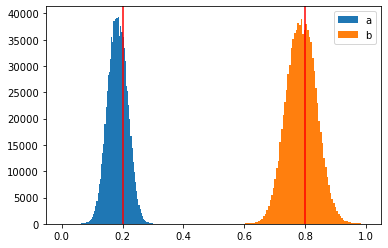

In [30]:
a = samples['params']['a']
b = samples['params']['b']
wa = samples['weights'][('a',)]
wb = samples['weights'][('b',)]
hist_a = plt.hist(a, weights = wa, bins = 100, label='a');
hist_b = plt.hist(b, weights = wb, bins = 100, label='b');
plt.axvline(par0['a'], color='r')
plt.axvline(par0['b'], color='r')
plt.legend();

In [33]:
mean_a = np.average(a, weights = wa)
std_a = np.average((a-mean_a)**2, weights = wa)**0.5
mean_b = np.average(b, weights = wb)
std_b = np.average((b-mean_b)**2, weights = wb)**0.5
print("a = %.4f +- %.4f"%(mean_a, std_a))
print("b = %.4f +- %.4f"%(mean_b, std_b))

a = 0.1836 +- 0.0323
b = 0.7891 +- 0.0494


Results evidently got better.  More training data will further help.

### Plot 2-dim posteriors

In [37]:
post2=s.gen_2d_marginals(N = 10000)

Generating marginals for: [('a',), ('a', 'b'), ('b',)]
Using volume: 0.04776241409544975


In [38]:
samples2 = post2(obs0, 1000000);

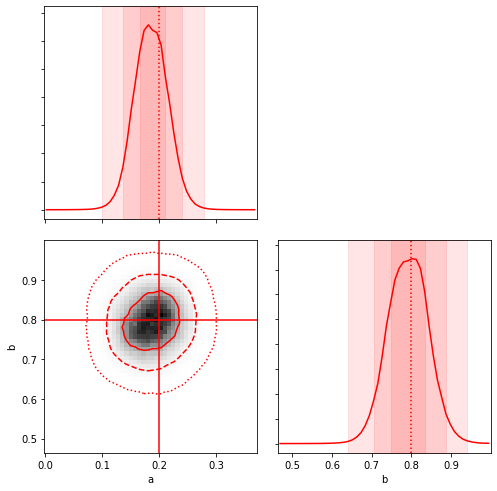

In [39]:
swyft.corner(samples2, ["a", "b"], color='r', figsize = (8,8), truth=par0, bins=50)

## Complex data and the `Head` network

The above methods work well for simple low-dimensional data, with characteristics that can be well learned by a simple Multi-Layer-Perceptron (MLP, which is at the core of SWYFT).  However, when analysing image data etc, much better performance can be achieved by using a pre-processor network that acts as feature extractor.

### Image model

In [40]:
prior = swyft.Prior({"x1": ['uniform', 0., 1.], "y1": ['uniform', 0., 1.],"r": ['uniform', 0., 1.]})

In [41]:
def simulator(params, w = 0.03):
    "Ring simulator"
    x1, y1, r = params['x1'], params['y1'], params['r']*0.5
    
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    
    # Add random distortions in terms of lines
    for _ in range(20):
        xr = np.random.rand(2)
        mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)
        
    return dict(x=mu)

def noise(obs, params = None, sigma=0.1):
    mu = obs['x']
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return dict(x=x)

We add some random very non-Gaussian noise (random straight lines) to make things more interesting.  Analyzing such an image with likelihood-based methods would introduce 40 extra nuisance parameters.  The traditional approach would be to generate samples from the 43-dim posterior, which significnatly complicates estimates of the ring parameters.  In *swyft*, we can instead just ignore those parameters, this is enough to marginalize them out.

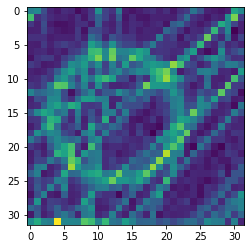

In [46]:
z0 = np.array([0.4, 0.5, 0.6])
param0 = {'x1': 0.4, 'y1': 0.5, 'r': 0.6}
mu0 = simulator(param0)
obs0 = noise(mu0)
plt.imshow(obs0['x']);

### Head network

We write a simple convolutional neural network as head network. The `forward` method has to take as input the data, and output a single vector. The network has to be written such that it can be batched.

In [89]:
from swyft.network import OnlineNormalizationLayer
from swyft.utils import Module

In [99]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self, obs_shapes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, obs):
        x = obs['x']
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

### Running the analysis

Analysing the image is now simple. We just provide an instance of the `Head` network as argument to `RatioEstimator`. That's it.

In [100]:
s = swyft.NestedRatios(simulator, prior, noise = noise, obs = obs0, device = DEVICE)

Creating new cache.


In [101]:
s.run(Ninit = 200, max_rounds=1,train_args = dict(lr_schedule = [1e-3, 1e-4]), head = Head)

Simulate:   9%|▉         | 18/191 [00:00<00:00, 176.66it/s]

NRE ROUND 0
  number of training samples is N = 200
  adding 191 new samples to simulator cache.


Simulate: 100%|██████████| 191/191 [00:00<00:00, 239.95it/s]


ModuleAttributeError: 'Head' object has no attribute 'n_features'

# HERE

In [24]:
points, re = run(x0, model, zdim = 3, noise = noisemodel, device = DEVICE, n_train = 5000, head = Head(), n_rounds = 1)

Simulate:   1%|▏         | 75/5002 [00:00<00:06, 741.70it/s]

Creating new cache.
Adding 5002 new samples. Run simulator!


Simulate: 100%|██████████| 5002/5002 [00:06<00:00, 738.36it/s]


yshape (shape of features between head and legs): 160
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 214.73997926712036
Validation loss: 200.60853910446167
Validation loss: 181.89602279663086
Validation loss: 179.31917333602905
Validation loss: 166.11947584152222
Validation loss: 168.93125295639038
Validation loss: 159.45267915725708
Validation loss: 157.61959052085876
Validation loss: 151.69198274612427
Validation loss: 155.2899465560913
Total epochs: 10
LR iteration 1
Validation loss: 143.69569182395935
Validation loss: 143.21844601631165
Validation loss: 141.3215925693512
Validation loss: 138.82679057121277
Validation loss: 138.3653585910797
Validation loss: 140.0353331565857
Validation loss: 140.06137585639954
Total epochs: 7


### 1-dim posteriors for reference image

And voila. The posteriors estimated by the network agree well with the input parameters.

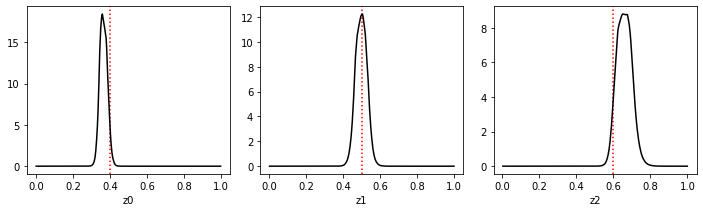

In [25]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (12, 3), ncol = 3, params = [0, 1, 2])

### Amortised posteriors

Since we only trained the network for one round - on the full model parameter space, we can actually also quickly generate posteriors for other images. This comes at no extra costs, since the network amortised all possible posteriors.

In [26]:
def plot_posterior():
    z0 = np.random.rand(3)
    mu0 = model(z0)
    x0 = noisemodel(mu0)
    plt.imshow(x0)
    swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (12, 3), ncol = 3, params = [0, 1, 2])
    

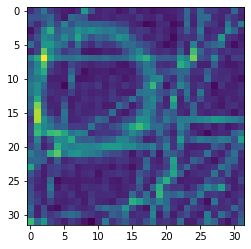

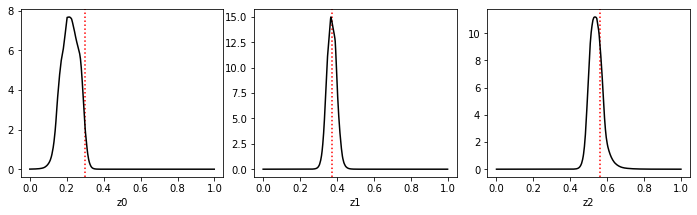

In [27]:
plot_posterior()

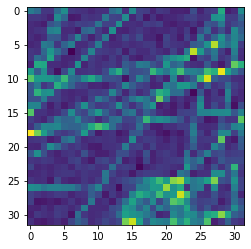

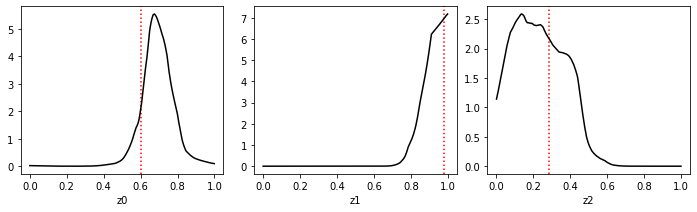

In [28]:
plot_posterior()

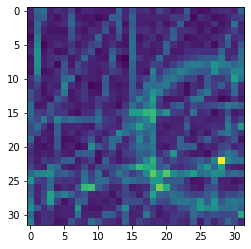

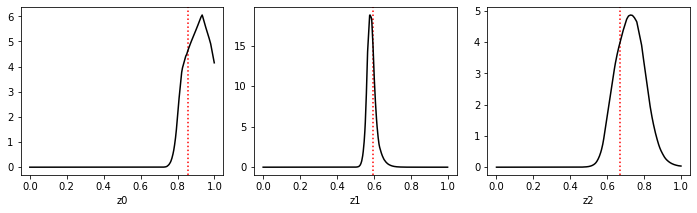

In [29]:
plot_posterior()

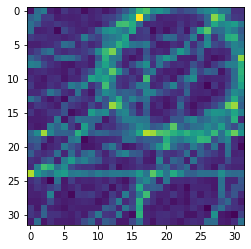

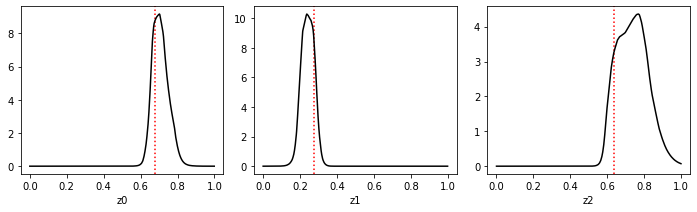

In [30]:
plot_posterior()

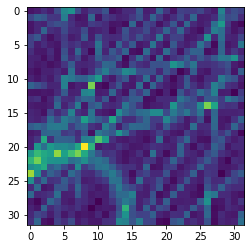

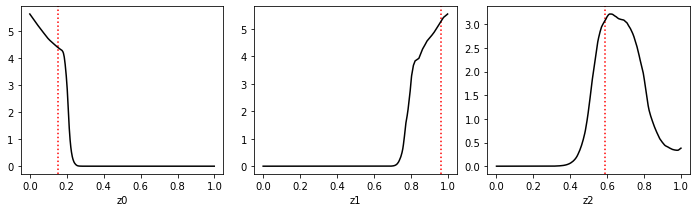

In [31]:
plot_posterior()

## Some final words - Unleashing the power of marginal posterior estimation

- It is notable that the last results are obtained with just 5000 training images and a very simple head network.  At the same time, obtaining similar results - even for a single image - with a pure likelihood-based approach would be rediciously challenging, since the full joint 43-dim posterior that would have to be explored has ~$10^{18}$ modes (the lines are permutation symmetric, which gives a factor $20!$).
- We note that more training data or a more expressive head network would potentially improve the quality of the results.
- More information about the underlying theory and the code structure can be found on https://swyft.readthedocs.io/en/latest/, as well as the papers that are referenced there.